# Introduction
Image classification is the process of taking an input (like a picture) and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”). You can look at a picture and know that you’re looking at a terrible shot of your own face, but how can a computer learn to do that? With a convolutional neural network!

-----
# Goals
We would like you to establish a neural network involving advance DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.)  to distinguish the specific category of an input image.

-------------
## Packages
Let's first import the necessary packages,

In [1]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import torchvision
import torchvision.transforms as transforms
import os


-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [2]:
print("GPU training is possible") if torch.cuda.is_available() else print("Only CPU training possible")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:",device)

GPU training is possible
Device in use: cuda


-----
## Configuration
### hyper parameters
We then set up and hyper parameters that need for the our model.
we need to define several hyper parameters for our model:
1. learning rate
2. batch size when training
3. batch size when testing
4. numbper of epoches
5. out put directory

In [3]:
learning_rate = 0.001
trainBatchSize = 70
testBatchSize = 70
epochs = 25

Create a directory if not exists
using os.path.exists() to check whether it is exist
using os.makedires to create a directory.

In [4]:
path = "data"
if not os.path.exists(path):
    os.makedirs(path)

-----
##  Data Loading
Next, we are going to load our data. 
### We need to prepare our data:

### We first import necessary librarys for data loading

In [5]:
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data
from ipywidgets import IntProgress

-----
###  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use .RandomHorizontalFlip()
3. You add any extra transforms you like.
4. Create this transform for both training set and testting set. Note that the testing spilit do not require any transform

In [6]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

-----
### We then download and prepare the data with the transforms defined above:
1. Use command torchvision.datasets.CIFAR10() with root, train, download and transform posional arguments.
2. Use the same command to create both train split and test split.
3. Use torch.utils.data.DataLoader() to create the data loader based on the data we have.
3. Use this command for both training split data loader and test split data loader

In [7]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=trainBatchSize, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=testBatchSize, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


-----
##  Network
Next, we are going to design our GoogLeNet
### First, we define our GoogLeNet class
### You need to refer the paepr below to understand the structure.
### https://arxiv.org/abs/1409.4842


<img src="./a.png" height="200" width="600">



<img src="./b.png" height="200" width="600">

------
### Inception Module with dimension reductions (There exist many implement methods)
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. Consists of 4 variables b1,b2,b3,b4
    
    3. b1 is a block consists of 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block consists of tow 2D convaluations, two 2D batch normalization layers and tow ReLU activation functions
    
    5. b3 is a block consists of three 2D convaluations, three 2D batch normalization layers and three ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the concatenation of all the output.

In [8]:
class CNN_Helper(nn.Module):
    def __init__(self, input_cls, output_cls, **kwargs):
        super(CNN_Helper, self).__init__()
        self.relu = nn.ReLU()
        self.convolution = nn.Conv2d(input_cls, output_cls, **kwargs)
        self.batchnorm = nn.BatchNorm2d(output_cls)
      
    def forward(self, x):
        return self.relu(self.batchnorm(self.convolution(x)))


#Our Inception Module Implementation
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()

      # 1x1 conv branch
        self.b1 = CNN_Helper(in_planes,kernel_1_x,kernel_size=1)

      # 1x1 conv -> 3x3 conv branch
      #self.b2 = nn.Sequential(
        self.b2 = nn.Sequential(CNN_Helper(in_planes,kernel_3_in,kernel_size=1),
                                CNN_Helper(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
      )

      # 1x1 conv -> 5x5 conv branch
      #self.b3 = nn.Sequential(
        self.b3 = nn.Sequential(CNN_Helper(in_planes, kernel_5_in, kernel_size=1),
                                CNN_Helper(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
                                CNN_Helper(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
      )

      # 3x3 pool -> 1x1 conv branch
      #self.b4 = nn.Sequential(
        self.b4 = nn.Sequential(nn.MaxPool2d(3, stride=1, padding=1),
                                CNN_Helper(in_planes, pool_planes, kernel_size=1),
      )
        
    def forward(self,x):
        b1_result = self.b1(x)
        b2_result = self.b2(x)
        b3_result = self.b3(x)
        b4_result = self.b4(x)
        return torch.cat([b1_result,b2_result,b3_result,b4_result],1)

-----
### GoogLeNet Module (There exist many implement methods)

<img src="./Picture1.png" height="1000" width="10000">


1. Create a python class called GoogLeNet which inherits nn.module

2. Create a init function to init this python class

    1. Consists of a variables that serves as all layers before the inception, which contains a 2D convaluation with padding=1, kernel_size=3 output channel=192, a 2D batch normalization layer and a ReLU activation fucntion.
    
    3. Two Inception block
    
    4. Maxpooling layer
    
    5. Seven Inception block
    
    6. Average Pooling layer
    
    7. A fully connected layer.
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the output

In [9]:
class GoogleNet(nn.Module):
    def __init__(self):
        super(GoogleNet, self).__init__()

        self.init_conv = CNN_Helper(3,192,kernel_size=3,padding=1)
        self.inception_1 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.inception_2 = Inception(256, 128, 128, 192, 32, 96, 64)
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        self.inception_3 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.inception_4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.inception_5 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.inception_6 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.inception_7 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.inception_8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception_9 = Inception(832, 384, 192, 384, 48, 128, 128)
        self.avg_pool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        output = self.init_conv(x)
        output = self.inception_1(output)
        output = self.inception_2(output)
        output = self.max_pool(output)
        output = self.inception_3(output)
        output = self.inception_4(output)
        output = self.inception_5(output)
        output = self.inception_6(output)
        output = self.inception_7(output)
        output = self.max_pool(output)
        output = self.inception_8(output)
        output = self.inception_9(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.linear(output)
        return output

### Next, we create the networka and send it to the target device

In [10]:
Convolutional_Neural_Network = GoogleNet().to(device)
print(Convolutional_Neural_Network)

GoogleNet(
  (init_conv): CNN_Helper(
    (relu): ReLU()
    (convolution): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (inception_1): Inception(
    (b1): CNN_Helper(
      (relu): ReLU()
      (convolution): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (b2): Sequential(
      (0): CNN_Helper(
        (relu): ReLU()
        (convolution): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): CNN_Helper(
        (relu): ReLU()
        (convolution): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (

### Finally, We create:
 1. an optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which is used to decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

In [11]:
opt = torch.optim.Adam(Convolutional_Neural_Network.parameters(), lr=learning_rate)
crit = nn.CrossEntropyLoss()
sch = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.05)

-----
##  Training
Then, we are going to train our Network

1. Set our network to the training model.
2. Init the train loss, total data and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backprop the loss
    6. Update the network parameters using the optimzier
    7. Accumulate the training loss
    8. Find the prediciton. hint: using torch.max()
    9. Increment the data size
    10. Increment the corrected prediction
    11. Print log
    
-----
##  Testing
Then, we are going to test our module

1. Set our network to the test model.
2. Init the test loss, total data and number corrected predictions. 
3. For each data in the training split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the training loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

-----
##  Epochs:
For each epoch:
1. we first step our scheduler
2. we train our module
3. we test our module
4. we update the testing accuracy
5. we save the module at the end and print the accuracy

In [12]:
num_steps = len(train_loader)
num_steps_test = len(test_loader)
loss_list = []
loss_list_test = []
acc_list = []

print(f'Training progress GoogleNet CNN. {epochs} epochs \n')
for e in range(epochs):
    print('Epoch:', (e+1),'Learning Rate::', sch.get_last_lr())
    total_train = 0
    correct_train = 0
    for i, (img, label) in enumerate(train_loader):
        img = img.to(device)
        label = label.to(device)
        opt.zero_grad()
        predicted_label = Convolutional_Neural_Network(img)
        loss = crit(predicted_label, label)
        loss.backward()
        opt.step()
        values,predictions = torch.max(predicted_label,1)
        total_train += label.size(0)
        correct_train += (predictions == label).sum().item()
        if (i+1) % 500 == 0:
            print (f'Epoch {e+1}, Step {i+1}/{num_steps}, Train Loss: {loss.item():.3f}')
        loss_list.append(loss.item())
    sch.step()
    with torch.no_grad():
        total_test = 0
        correct_test = 0

        for i,(images,labels) in enumerate(test_loader):
            images = images.to(device)
            labels= labels.to(device)
            test_result = Convolutional_Neural_Network(images)
            loss = crit(test_result, labels)
            values,predictions = torch.max(test_result,1)
            loss_list_test.append(loss.item())
            total_test += labels.size(0)
            correct_test += (predictions == labels).sum().item()
            if (i+1) % 80 == 0:
                print (f'Epoch {e+1}, Step {i+1}/{num_steps_test}, Test Loss: {loss.item():.3f}')

        epoch_test_acc = 100* (correct_test/total_test)
        epoch_train_acc = 100* (correct_train/total_train)
        print(f'Epoch Test Acurracy {epoch_test_acc}')
        print(f'Epoch Train Acurracy {epoch_train_acc} \n')
        acc_list.append(epoch_test_acc)

Training progress GoogleNet CNN. 25 epochs 

Epoch: 1 Learning Rate:: [0.001]
Epoch 1, Step 500/715, Train Loss: 0.927
Epoch 1, Step 80/143, Test Loss: 1.131
Epoch Test Acurracy 66.60000000000001
Epoch Train Acurracy 54.379999999999995 

Epoch: 2 Learning Rate:: [0.001]
Epoch 2, Step 500/715, Train Loss: 0.738
Epoch 2, Step 80/143, Test Loss: 0.740
Epoch Test Acurracy 75.59
Epoch Train Acurracy 72.478 

Epoch: 3 Learning Rate:: [0.001]
Epoch 3, Step 500/715, Train Loss: 0.635
Epoch 3, Step 80/143, Test Loss: 0.745
Epoch Test Acurracy 79.55
Epoch Train Acurracy 78.926 

Epoch: 4 Learning Rate:: [0.001]
Epoch 4, Step 500/715, Train Loss: 0.505
Epoch 4, Step 80/143, Test Loss: 0.597
Epoch Test Acurracy 82.62
Epoch Train Acurracy 82.686 

Epoch: 5 Learning Rate:: [5e-05]
Epoch 5, Step 500/715, Train Loss: 0.262
Epoch 5, Step 80/143, Test Loss: 0.443
Epoch Test Acurracy 86.35000000000001
Epoch Train Acurracy 88.44 

Epoch: 6 Learning Rate:: [5e-05]
Epoch 6, Step 500/715, Train Loss: 0.272
E

# Accuracy Overview

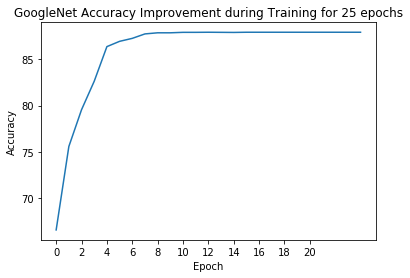

In [34]:
import matplotlib.pyplot as plt
plt.plot(acc_list)
plt.xticks(np.arange(0,21,2))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'GoogleNet Accuracy Improvement during Training for {epochs} epochs')
plt.show()

# Loss Convergence

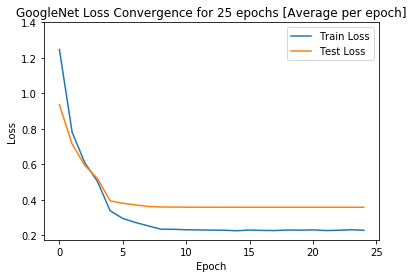

In [38]:
#Get the average loss per epoch
losses_array = np.array(loss_list)
losses_array_test = np.array(loss_list_test)
average_loss_per_echo_train = np.mean(losses_array.reshape(-1, 715), axis=1)
average_loss_per_echo_test = np.mean(losses_array_test.reshape(-1, 143), axis=1)
plt.plot(average_loss_per_echo_train, label="Train Loss")
plt.plot(average_loss_per_echo_test, label="Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks(np.arange(0.2,1.5,0.2))
plt.legend()

plt.title(f'GoogleNet Loss Convergence for {epochs} epochs [Average per epoch]')
plt.show()
plt.show()

# Report - Structure

In my implementation to make my code a bit easier to read and also to understand I created three classes instead of 
just the two classes prescribed in the pseudocode. I made on CNN_Helper class, one Inception Class and a GoogleNet Class. The inception class leverages the CNN_Helper class in order to make things easier. Furthermore, the GoogleNet Class utilises the Inception Class

This is what happens during each epoch in my code during the training phase.

(1) First, the schedule is stepped in order to reduce the learning rate after every n steps. (2) Then, Using the optimizer the gradients are set to 0. (3) After this, the loss is calculated and labels are predicted. (4) Subsequently, backpropogation takes place through the loss.backward() function. (5) Next, the gradients are updated with the optimizer.step() function. (6) Then steps 1 to 4 are repeated for all batches in the train_loader. (7) Finally after training the accuracy is calculated using  test data.
